In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns; sns.set_theme()
import string
import analysis_functions as funcs
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import (cm, colors,cycler)
import matplotlib.path as mpath
import matplotlib
import xclim as xc

from matplotlib.legend_handler import HandlerTuple

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def global_mean(ds):
    lat = ds['lat']
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)
                             
def zonal_mean(ds):
    lat = ds['lat']
    other_dims = set(ds.dims) - {'lat'}
    return ds.mean(other_dims)

In [5]:
models = []
labels = []
ds_solar = xr.open_mfdataset('/badc/cmip6/data/CMIP6/GeoMIP/MOHC/UKESM1-0-LL/G6solar/r1i1p1f2/day/tasmax/gn/files/d20191031/*')
# solar dimming experiments, surface temperature
models.append(ds_solar)
labels.append('G6solar')

ds_sulfur = xr.open_mfdataset('/badc/cmip6/data/CMIP6/GeoMIP/MOHC/UKESM1-0-LL/G6sulfur/r1i1p1f2/day/tasmax/gn/files/d20191113/*')
# sulfur injection experiment, surface temperature
models.append(ds_sulfur)
labels.append('G6sulfur')

ds_245 = xr.open_mfdataset('/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/r1i1p1f2/day/tasmax/gn/v20190715/*')
# ssp 5, rcp8.5, surface temperature
models.append(ds_245)
labels.append('ssp245')

ds_585 = xr.open_mfdataset('/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/day/tasmax/gn/v20190726/*')
# ssp 5, rcp8.5, surface temperature
models.append(ds_585)
labels.append('ssp585')

ds_G1 = xr.open_mfdataset('/badc/cmip6/data/CMIP6/GeoMIP/MOHC/UKESM1-0-LL/G1/r1i1p1f2/day/tasmax/gn/files/d20190916/*')
# weak solar dimming perhaps?, surface temperature
labels.append('G1')

ds_piC = xr.open_mfdataset('/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/' + \
                           'piControl/r1i1p1f2/day/tasmax/gn/files/d20191008/*')#.isel(time=slice(0,1200))
labels.append('piControl')

In [6]:
modelist = models.copy()

for i in range(len(modelist)):
    m = modelist[i]
    m = m.sel(time = slice("2090", "2100"))
    m = xc.atmos.tx_max(m.tasmax, freq='MS')
    m = m.mean(dim = "time")
    modelist[i] = m

In [7]:
def tropics_mean(ds):
    ds = ds.where(ds.lat < 20, drop = True)
    ds = ds.where(ds.lat > -20, drop = True)
    lat = ds['lat']
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

series = models.copy()

series.append(ds_G1)
series.append(ds_piC)


for i in range(len(series)):
    m = series[i]
    m = xc.atmos.tx_max(m.tasmax, freq='MS')
    m = tropics_mean(m)
    series[i] = m
    

KeyboardInterrupt: 

In [8]:
diffs = []


diffs.append(modelist[0] - modelist[2])
diffs.append(modelist[1] - modelist[2])
diffs.append(modelist[0] - modelist[3])
diffs.append(modelist[1] - modelist[3])
diffs.append(modelist[0] - modelist[1])

In [ ]:
plt.figure(figsize=(8, 4), dpi=150)

for i in range(len(series)):
    print(i)
    m = series[i]
    l = labels[i]
    plt.plot((m-273).rolling(time=12).mean().values,lw=2,label=l)

plt.grid()
#plt.ylim([14,22])
plt.ylabel('Temperature ($^{\circ}$C)')
plt.xlabel('months')
plt.legend()
plt.title('Daily maximum temperature (2090-2100), $^{\circ}$C)')
plt.show()

ERROR:fiona._env:PROJ: proj_identify: Cannot find proj.db


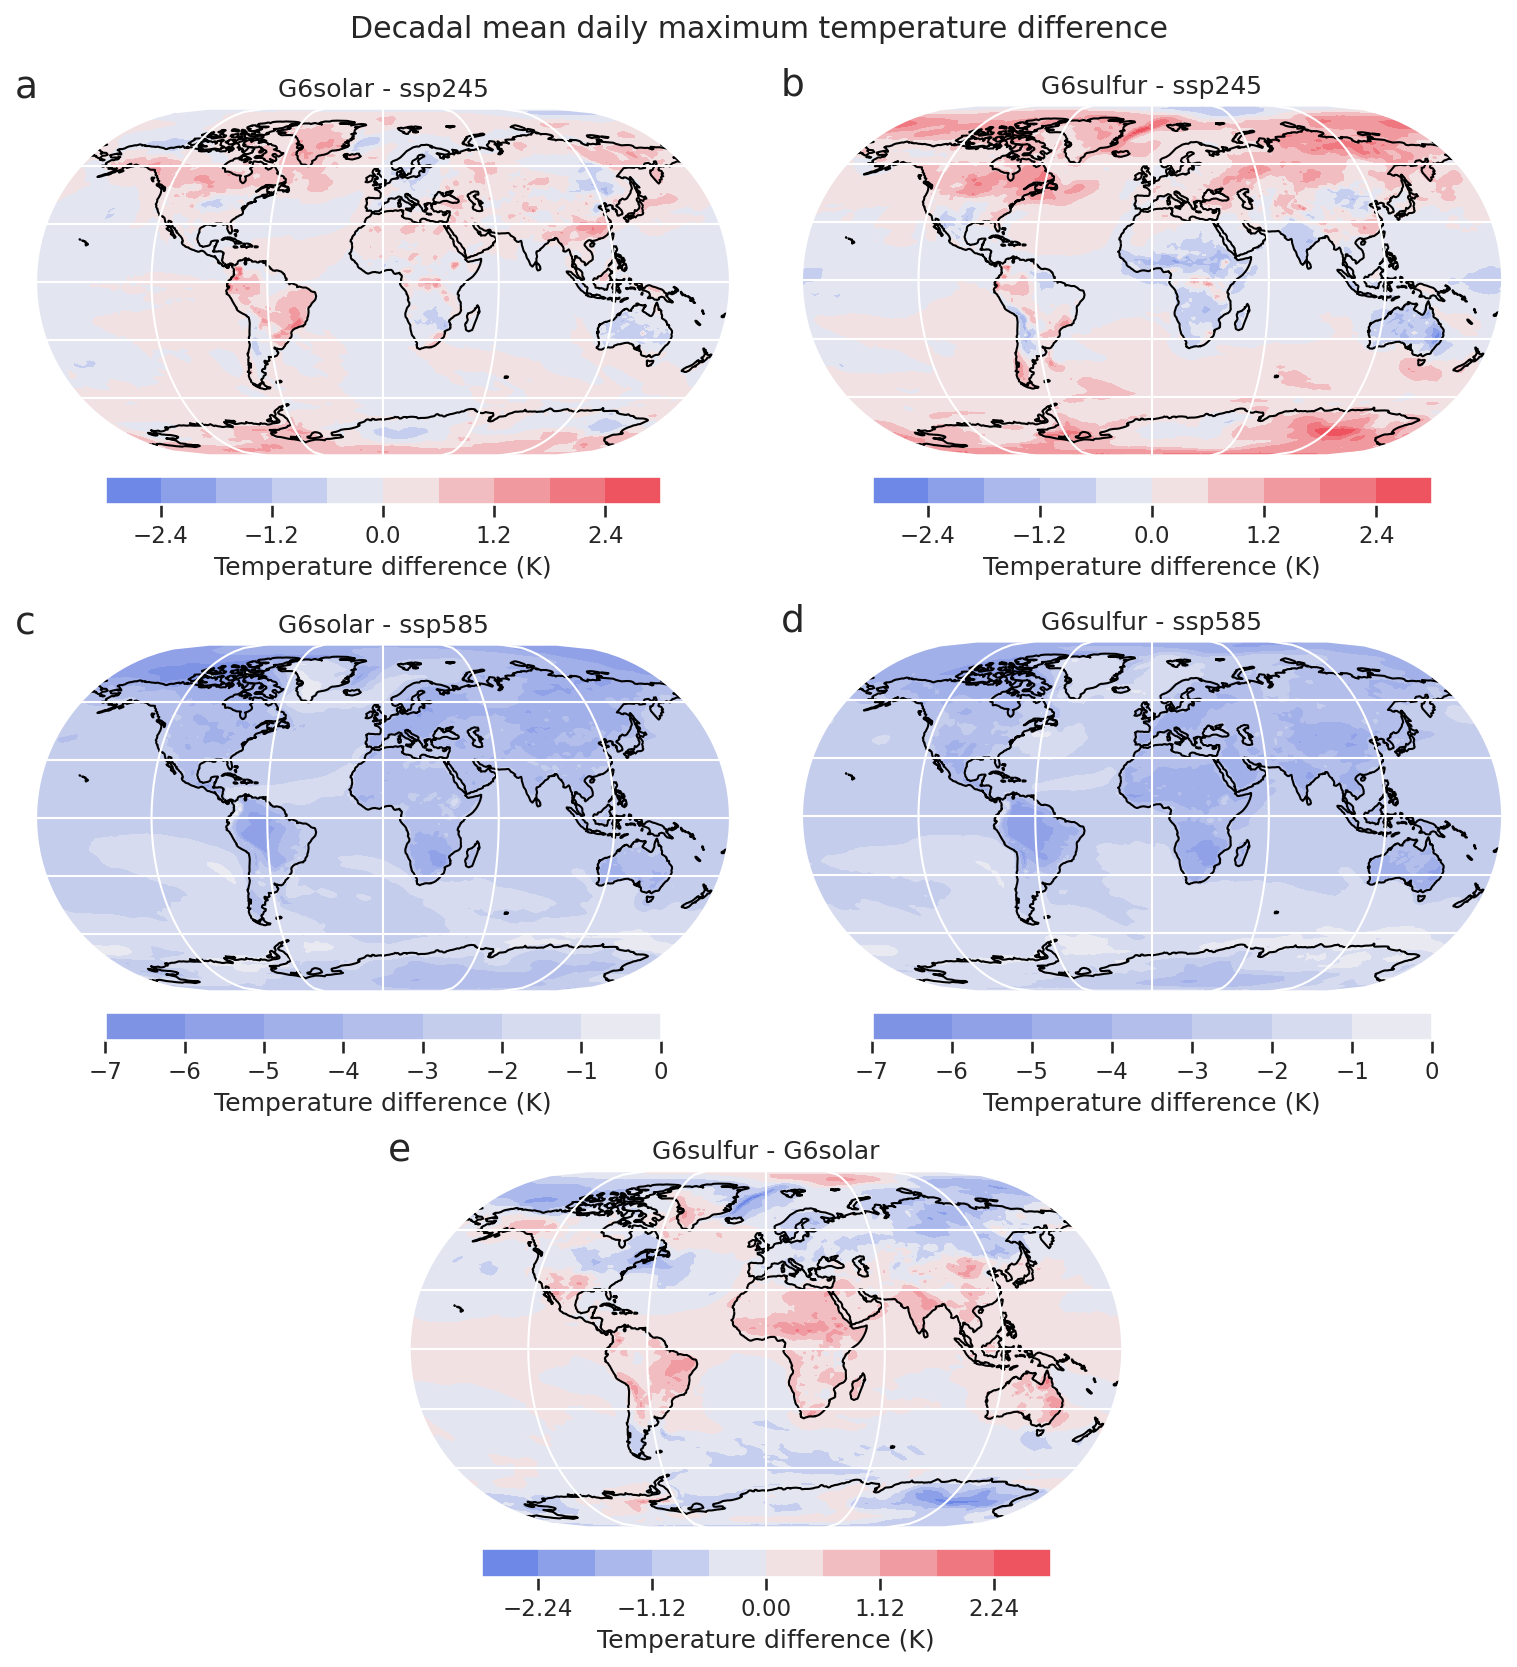

In [9]:
cmap1 = sns.diverging_palette(260,10,s=80, l=55, n=17, as_cmap=True)
cmap2 = sns.light_palette((260, 75, 60), input = "husl", reverse=True,
                          as_cmap=True)
fig = plt.figure(constrained_layout=True, figsize = (10,11), dpi= 150,
                )
ax_dict = fig.subplot_mosaic(
    """
    AABB
    CCDD
    .EE.
    """,
    subplot_kw = {'projection':ccrs.EckertIII()}
)

for j, ax in enumerate(fig.axes):
    dat = diffs[j]
    lon = dat.lon.values
    lat = dat.lat.values
    ax.text(-0.03, 1.03, string.ascii_lowercase[j], transform=ax.transAxes, 
            size=18,)
    gl = ax.gridlines(crs = ccrs.PlateCarree())
    if j < 2:
        l = labels[j]
        ax.set_title(l+' - ssp245')
        levels = np.linspace(-3, 3, 11)
        cmap = cmap1
    elif 2 <= j < 4:
        l = labels[j-2]
        ax.set_title(l+' - ssp585')
        levels = np.linspace(-7,0,8)
        cmap = cmap2
    else:
        ax.set_title(labels[1] + ' - ' + labels[0])
        levels = np.linspace(-2.8,2.8,11)
        cmap = cmap1
    #gl.ylocator = ticker.FixedLocator([-60,-30,0,30,60])
    #gl.xlocator = ticker.FixedLocator([0,60,120,180,240,300,360])
    filled_c = ax.contourf(lon, lat, dat,
           transform=ccrs.PlateCarree(), levels=levels,
           cmap=cmap)
    
    cb = fig.colorbar(filled_c, ax = ax, orientation="horizontal",
                      shrink = 0.8)
    cb.set_label(label = 'Temperature difference (K)')
    #ax.contourf(dat,
    #        projection=ccrs.Robinson())
    ax.coastlines()
    
        
    ax.set_global()

fig.suptitle('Decadal mean daily maximum temperature difference')
plt.show()

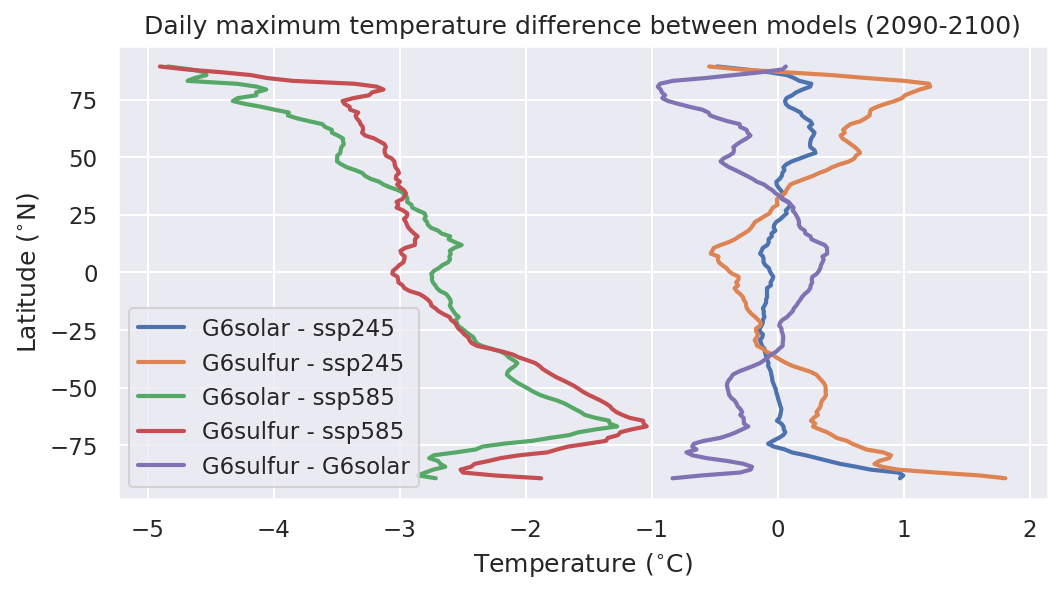

In [22]:
def zonal_mean(ds):
    lat = ds['lat']
    other_dims = set(ds.dims) - {'lat'}
    return ds.mean(other_dims)


dfs = []

plt.figure(figsize=(8, 4), dpi=150)


    
for j in range(len(diffs)):
    dat = diffs[j].mean(dim="lon")
    if j < 2:
        l = labels[j]+' - ssp245'
    elif 2 <= j < 4:
        l = labels[j-2]+' - ssp585'
    else:
        l=labels[1] + ' - ' + labels[0]
    plt.plot(dat,dat.lat,lw=2,label=l)
    
#plt.grid()
#plt.ylim([14,22])
plt.ylabel('Latitude ($^{\circ}$N)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.legend()
plt.title('Daily maximum temperature difference between models (2090-2100)')
plt.show()
    